# King County Housing Predictions
### Using Linear Regression to predict housing prices in Seattle

## Table of Contents
### 1) Geolocation Data
### 2) Seasonal Data
### 3) Feature Interactions
### 4) Constructing my model piecewise
### 5) Testing the model
### 6) Lasso regression vs Linear Regression and model selection


In [1]:
# import src 

# sklearn packages
from sklearn.feature_selection import RFE, SelectKBest, f_regression, RFECV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler ,minmax_scale, PolynomialFeatures, StandardScaler

# Statsmodels
from statsmodels.formula.api import ols

# Geolocation
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

# utility libraries 
from scipy.stats import f_oneway
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geohash2
import itertools

import warnings 

sns.set_style('whitegrid')

# filter warnings
warnings.filterwarnings("ignore")

# magic inline
%matplotlib inline

# Exploratory Data Analysis

## How does the houses location effect price?
### Dealing with Geolocation data

In [2]:
# import raw data 
geo = pd.read_csv('./cleanedData/geoOverlap.csv')
X = pd.read_csv('./cleanedData/X.imputed.csv', index_col=0) # imputed median for bed and bath where they == 0
y = pd.read_csv('./raw/y.csv', header = None) # training y
y.columns = ['price']
holdout = pd.read_csv('./raw/kc_holdout_data.csv') # holdout
training_data = pd.concat([X, y], axis=1)

No handles with labels found to put in legend.


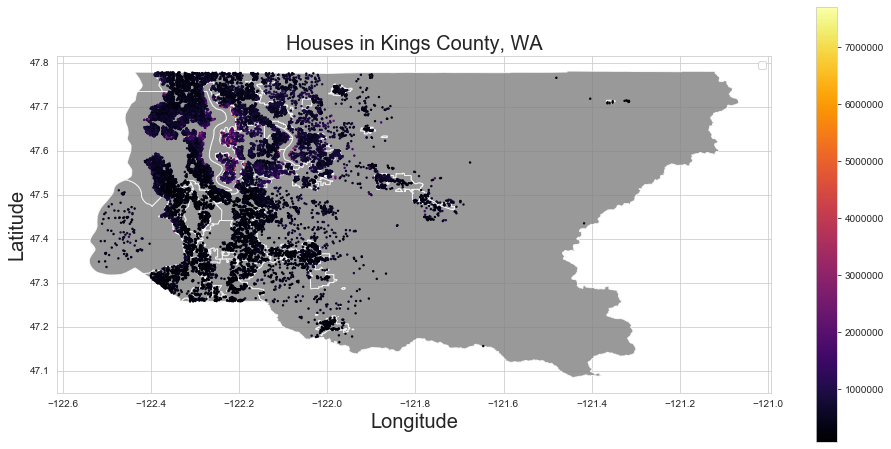

In [3]:
# Let's get rid of the everything but the price, longitude and latitude for now
geometry = [Point(xy) for xy in zip(training_data["long"], training_data["lat"])]
geometry[:5]

# Horizontal component of 3D system. 
# Used by the GPS satellite navigation 
# system and for NATO military geodetic surveying.
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(training_data,
                         crs=crs,
                         geometry=geometry)

map_df = gpd.read_file("./raw/mapping/kingscounty-shp/Cities_and_Unincorporated_King_County___city_kc_area.shp")

fig, ax = plt.subplots(figsize = (16,8))
map_df.plot(ax=ax, alpha = 0.8, color = 'Grey')
geo_df.plot(ax=ax,
            column ='price',
            cmap = 'inferno', 
            legend=True ,
            markersize = 2,
            marker = 'o',
            aspect = 1
           )
# geo_df.plot(ax = ax , markersize = 2, color = 'blue',marker =
#             'o',label = 'House', aspect = 1)
plt.legend(prop = {'size':10} )
ax.set_title('Houses in Kings County, WA', fontdict = {'fontsize':
                20})
ax.set_ylabel('Latitude',fontdict = {'fontsize': 20})
ax.set_xlabel('Longitude',fontdict = {'fontsize': 20});

fig.savefig('./images/kingcountyMap.png')

### If I had more time I would create a folium map with city limits but the story of the data is quite clear.

There is a tight region where the housing prices are particulalry high. They surround a body of water so anything near a coast should have higher prices. In our data set, houses with an ocean view have a significantly higher median price.

I would also like to look into distance from parks and utilities like schools in my data set. Arcpy is a package that I have been looking into to implement this. 

In [4]:
# null hypothesis is that there is no difference between the means of waterfront and non waterfront properties
# alternative hypothesis is that there is a significant difference between the means
delta=training_data[training_data.waterfront == 1].price.median() - training_data[training_data.waterfront == 0].price.median()

stats.levene(training_data[training_data.waterfront == 1].price, 
              training_data[training_data.waterfront == 0].price) 
stat= stats.ttest_ind(training_data[training_data.waterfront == 1].price,
                training_data[training_data.waterfront == 0].price, 
                equal_var=False)



print(f'The median difference in price between homes with a coastal view and those with out is {delta} \
which is statistically signeficant with a p_value of {stat[1]}')

The median difference in price between homes with a coastal view and those with out is 955000.0 which is statistically signeficant with a p_value of 6.940441256090536e-23


### Zipcodes as a linear regression feature

Since I know that some regions have a much higher average price than others, I can test whether or not price and zipcodes are correlated. Zipcodes are ordinal in that close regions share prefix's but I hypothesise that treating zipcodes as categorical will yeild better results than if we just had it as a column.

we can test this hypothesis by running two regressor models and comparing the R squared for each

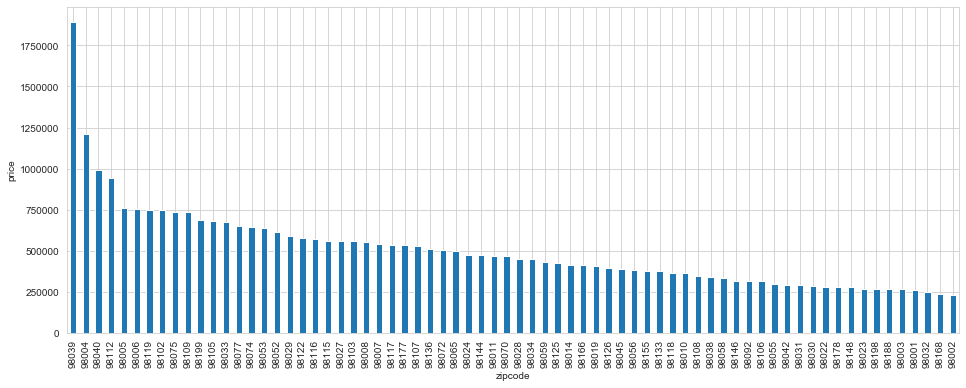

In [5]:
# median housing price per zipcode
zipcode_groupby = training_data.groupby(['zipcode']).price.median().sort_values(ascending=False)
plt.figure(figsize=(16,6))
plt.ylabel('price')
zipcode_groupby.plot(kind='bar');

In [6]:
zipcode_dummies = pd.get_dummies(X.zipcode).iloc[:,:-1] # removing 1 zipcode as the reference zipcode
zipcodes = X['zipcode']

lr1 = LinearRegression().fit(pd.DataFrame(zipcodes), y)
lr2 = LinearRegression().fit(zipcode_dummies, y)
lr1_yHat = lr1.predict(pd.DataFrame(zipcodes))
lr2_yHat = lr2.predict(zipcode_dummies)

RMSE1 = mean_squared_error(y,lr1_yHat)**0.5
RMSE2 = mean_squared_error(y, lr2_yHat)**0.5

print(f"zipcodes as ordinals RMSE = {RMSE1} \n\
zipcodes as dummies gave an RMSE of {RMSE2}")

zipcodes as ordinals RMSE = 372860.51696325414 
zipcodes as dummies gave an RMSE of 288813.04959021363


We will use the zipcodes as dummy variables moving forward. 

### Latitude and Longitudes as features aka Geohashing

The only things that actually correlate with latitiude and longitude are the average daylight hours and temperature over the year. Since I want to know how location effects price, I will instead use a package called geohash2. 

Geohash2 uses non-euclidean, haversine geodesic geometry to "bucket" a region into zones based on a space filling z-curve (https://en.m.wikipedia.org/wiki/Z-order_curve) and then assigns a hash value to that zone. Neighbouring zones share prefixes. But we are more interested in which zones have the strongest correlation on price. Therefore, similar to zipcodes, I will bucket the geohashes as they are strickly categorical

From the graph below, we can see that there are now 4 regions that are visually more pricey than the others. We have increased the granualarity of our observations. 

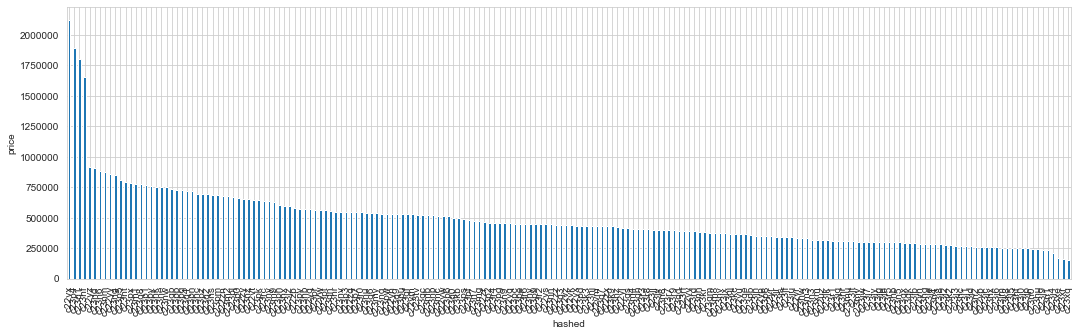

In [7]:
# create a location df with just lat and long
def geo_hash(lat, long):
    return geohash2.encode(lat, long, 5)

location = training_data[['lat', 'long']]
# create a hashed location column in the location data base
location['hashed_location'] =location.apply(lambda x: geo_hash(x['lat'], x['long']), axis=1)

# Add the hashed_location to the training data
training_data['hashed'] = location.hashed_location

# plot the hashed data with price
plt.figure(figsize=(18,5))

plt.ylabel('price')
training_data.groupby(['hashed']).price.median().sort_values(ascending=False).plot(kind='bar');

### We have split the high price location into more regions and smoothed out our curve.
I will make dummy columns for the this data and the holdout data, see the supplementary notebooks `trainGeohashing.ipynb` and  `geohashingClustering.ipynb`.

Through visual analysis, it appears that 1 (98093) zipcode and 4 of the geohashes have signeficantly large mean house prices. When we come to model building and feature selection we will test the importance of each geo hash more rigorously. Let's check that none of the geohashed regions have less than 30 observations

In [8]:
training_data.groupby(['hashed']).price.count().sort_values()[:10]

hashed
c23k3    1
c23k9    1
c23qx    1
c23r5    1
c23r7    1
c23q1    1
c23rc    1
c22vx    1
c23mc    1
c23xm    1
Name: price, dtype: int64

I do not want to drop these columns yet, but when we start working on feature selection, we will have to make a decision about these outliers. In addition, I know that not all geohashes are shared between groups. Let's check the shared geohashes. It looks like we have narrowed down the number of geohashes shared between the sets to just 5. Less of a big deal to drop these. Let's check to see what

In [9]:
shared_geo = pd.read_csv('./cleanedData/geoOverlap.csv', index_col=0)
boolean = shared_geo != 0
only_one = boolean.sum().sort_values()[:5].index
interest = shared_geo[only_one]

# get the indexs that I need to check on the house locations
interest_index = [interest[interest[column] ==1].index[0] for column in interest.columns]
X.iloc[interest_index]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
13592,323079101,20150123T000000,4,3.50,6370,205603,2.0,0,0,3,12,6370,0,2008,0,98027,47.5016,-121.905,1490,33580
17081,821079102,20141017T000000,4,3.50,3720,213073,1.0,0,2,3,10,3720,0,2007,0,98010,47.3216,-121.940,2190,59241
17048,522079068,20150506T000000,3,2.50,2150,161607,2.0,0,0,3,7,1330,820,1995,0,98038,47.4178,-121.937,2400,207781
13386,774101755,20150417T000000,3,1.75,1790,66250,1.5,0,0,3,7,1790,0,2003,0,98014,47.7179,-121.403,1440,59346
3262,820079043,20140819T000000,3,1.75,1580,507038,1.0,0,2,4,7,1580,0,1985,0,98022,47.2303,-121.936,2040,210394


Upon visual inspection of the houses in google maps, I can confirm that they are all normal, nice houses and I don't see why I should remove them outright from the data frame. However, when it comes to feature selection and model development I will make my decision.

## Does the time of the year effect the price of a house?
### Dealing with time series data

I am not fully equiped to deal with time series data yet. However, I will do some binning and dummy creations as best as I can. In addition, I suspect there is a polynomial relationship between week of the year and price. 

Let's visually inspect months

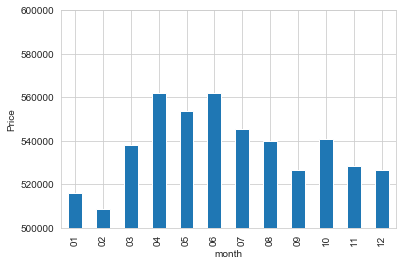

In [10]:
# Create a datetime object from the date column
datetime = pd.to_datetime(X.date)
# convert the date to months
month = datetime.dt.strftime("%m")
# append the months column to the dataframe
X['month'] = month
# Plot the month data against month
month_df = pd.concat([X['month'], y], axis=1)
month_df.groupby(['month']).price.mean().plot(kind='bar')
plt.ylim(500000,600000)
plt.ylabel('Price')
plt.title("");

#### Visual inspection suggests  month 4-6 behave differently to months 3,7,8,10 and different still to 1,2,11,12

I will perform ttests between the three "seasons" to confirm a difference

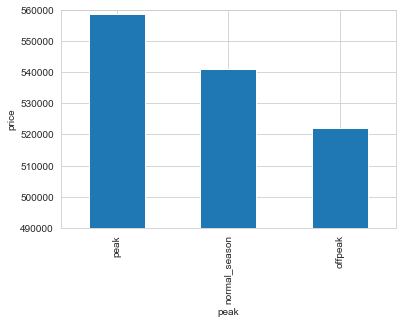

In [11]:
def peak_season(month):
    if month in [4,5,6]:
        return 'peak'
    elif month in [1,2,9,11,12]:
        return 'offpeak'
    else:
        return 'normal_season'

test = pd.concat([X, y], axis=1)
test.month = test.month.astype(int)

test['peak'] = test.month.apply(peak_season)

test.groupby('peak').price.mean().sort_values(ascending=False).plot(kind='bar')
plt.ylabel("price")
plt.ylim(490000, 560000)
plt.savefig('./images/seasons.png');

In [12]:
### Perform two tailed t tests between the groups

peak = test[test.peak == 'peak']
offpeak = test[test.peak == 'offpeak']
normal = test[test.peak == 'normal_season']

# peak vs off peak ttest 
print("peak vs off peak:")
print(f"peak vs off peak mean difference: {peak.price.mean() - offpeak.price.mean()}")
stats.levene(peak.price, offpeak.price) # Levenes Rejected
print(f"peak vs off peak p value: {stats.ttest_ind(peak.price, offpeak.price, equal_var=False)[1]}")
print("*"*60)
print("peak vs regular season:")
# peak vs regular season
print(f"peak vs regular season mean difference: {peak.price.mean()-normal.price.mean()}")
stats.levene(peak.price, normal.price) # Levens Failed to reject
print(f"peak vs regular season p value: {stats.ttest_ind(peak.price, normal.price)[1]}") # significant 
print("*"*60)
print("normal vs offpeak:")
# normal season vs offpeak
print(f"normal season vs offpeak mean difference: {normal.price.mean() -  offpeak.price.mean()}")
stats.levene(normal.price, offpeak.price) # Rejected
print(f"normal season vs offpeak p value: {stats.ttest_ind(normal.price, offpeak.price, equal_var=False)[1]}")

peak vs off peak:
peak vs off peak mean difference: 36720.238000085636
peak vs off peak p value: 2.334085061315023e-07
************************************************************
peak vs regular season:
peak vs regular season mean difference: 17824.835047457367
peak vs regular season p value: 0.011016854999620442
************************************************************
normal vs offpeak:
normal season vs offpeak mean difference: 18895.40295262827
normal season vs offpeak p value: 0.005178077743120801


### Test the polynomial nature of week on price

The graph of weeks vs price apears to follow a sin wave. I will two things, I will first just fit a polynomial, then I will fit a sin wave and see which performs better

In [13]:
week = datetime.dt.strftime("%W")
X['week'] = week.astype(int)
X['week^2'] = X['week']**2
X['week^3'] = X['week']**3
X['week^4'] = X['week']**4
X['week^5'] = X['week']**5
X['week^6'] = X['week']**6
X['week^7'] = X['week']**7
week_df = X[['week','week^2','week^3', 'week^4', 'week^5', 'week^6', 'week^7']]

dummy_predictor = DummyRegressor().fit(X,y)
dumb_hat = dummy_predictor.predict(X)
RMSE_dumb = mean_squared_error(y, dumb_hat)**0.5


lr = LinearRegression().fit(week_df, y)
y_hat = lr.predict(week_df)
RMSE = mean_squared_error(y , y_hat)**0.5
print(f"The RMSE for the polynomial weekly function is {RMSE} and dummy was {RMSE_dumb}")

The RMSE for the polynomial weekly function is 373018.22338589095 and dummy was 373308.18278696557


A polynomial fit for time did not work in this instance. But what about month? Month doesn't show a strong relationship with price either. 

In [14]:
month_df.drop(columns=['price'], inplace=True)
month_df['month'] = month_df.month.astype(int)
month_df['month^2'] = month_df['month']**2
month_df['month^3'] = month_df['month']**3
month_df['month^4'] = month_df['month']**4

lr = LinearRegression().fit(month_df, y)
y_hat = lr.predict(month_df)
RMSE = mean_squared_error(y , y_hat)**0.5
print(f"The RMSE for the polynomial weekly function is {RMSE} and dummy was {RMSE_dumb}")

The RMSE for the polynomial weekly function is 373073.8801748056 and dummy was 373308.18278696557


#### The last hypothesis to test is month as a categorical data

Though they did not have an effect on the RMSE, I will try adding dummy months as an interaction in the model building phase

In [15]:
month_dummies = pd.get_dummies(month_df.month).iloc[:,:-1] # remove december as reference column

lr = LinearRegression().fit(month_dummies , y)
y_hat = lr.predict(month_dummies)
RMSE = mean_squared_error(y , y_hat)**0.5
print(f"The RMSE for the monthly dummies is {RMSE} and dummy was {RMSE_dumb}")

The RMSE for the monthly dummies is 372987.19020239706 and dummy was 373308.18278696557


In [16]:
season_dummies = pd.get_dummies(test.peak)#.iloc[:,:-1] # remvoing one season as refrence
lr = LinearRegression().fit(season_dummies , y)
y_hat = lr.predict(season_dummies)
RMSE = mean_squared_error(y , y_hat)**0.5
print(f"The RMSE for the monthly dummies is {RMSE} and dummy was {RMSE_dumb}")

The RMSE for the monthly dummies is 373022.933888759 and dummy was 373308.18278696557


## Is there a combination between features that increases the cost of a home?

### Find all the interactions between features

First, I'll check for colinearity and then I will check for interactions between all features. I did my exploratory data analysis in `./eda/` and I will be referencing key findings as we progress through this notebook.


In [17]:
X = X.drop(columns = ['id', 'date'])
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,sqft_living15,sqft_lot15,month,week,week^2,week^3,week^4,week^5,week^6,week^7
0,4,2.25,2070,8893,2.0,0,0,4,8,2070,...,2390,7700,10,40,1600,64000,2560000,102400000,4096000000,163840000000
1,5,3.00,2900,6730,1.0,0,0,5,8,1830,...,2370,6283,08,33,1089,35937,1185921,39135393,1291467969,42618442977
2,4,2.50,3770,10893,2.0,0,2,3,11,3770,...,3710,9685,08,32,1024,32768,1048576,33554432,1073741824,34359738368
3,3,3.50,4560,14608,2.0,0,2,3,12,4560,...,4050,14226,03,13,169,2197,28561,371293,4826809,62748517
4,3,2.50,2550,5376,2.0,0,0,3,9,2550,...,2250,4050,07,28,784,21952,614656,17210368,481890304,13492928512


In [18]:
# Split data into types
discrete_features = [
    'bedrooms',
    'bathrooms',
    'floors',
    'yr_built',
]

ordinal_features = [
    'condition',
    'grade',
#     'zipcode',
    'view',   
]

continuous_features = [
    'sqft_living',
    'sqft_lot',
    'sqft_above',
#     'lat', # Removed as I have already handled this 
#     'long', # Removed as I have already handled this 
    'sqft_living15',
    'sqft_lot15',
    'yr_renovated'
]

dummy = [
    'waterfront',
    'sqft_basement', # Since most are none at all, I will ultimately be treating this column like a dummy in my model
]

### Discrete Variables 

Discrete variables are countable and ordered. In our data set, I am interested in the combinations of categorical, discrete and continuous variables and the potential interaction between them. During the model building phase I intend on testing the interaction between all of the data types, but it is good to visualise them here.

The data is typical of discrete data. The exception is year built. Indeed, I will change the year built column to age column by subtracting the year built from 2015. But everything else looks ok. I don't think any columns qualify for non-linear transformations

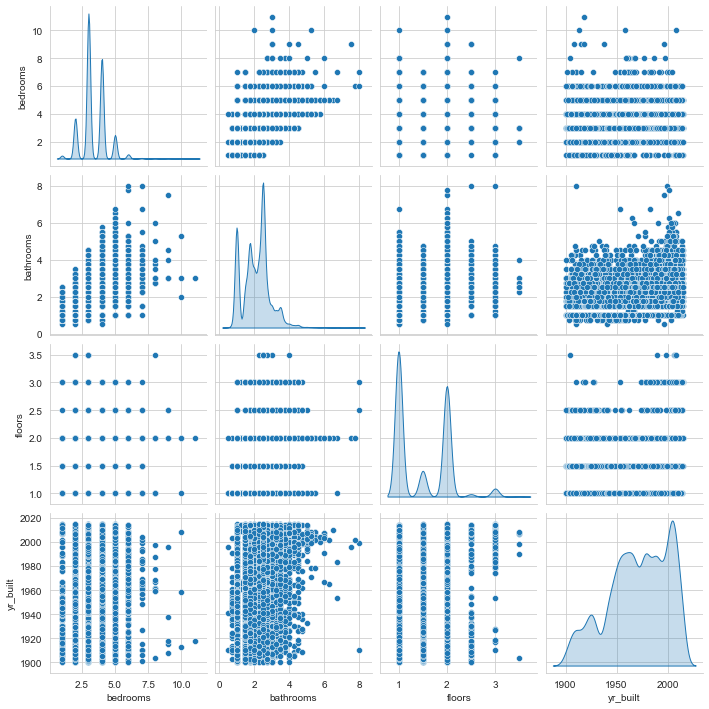

In [19]:
# Discrete Variables
sns.pairplot(X[discrete_features] , diag_kind='kde');

## Ordinal variables

Ordinal variables are categorical but they have an order to them. Grade 1 is worse than grade 13 for instance and each of these features are of this kind.

most of the data looks ok but view is heavily skewed. There may be opportunity to do a non-linear transformation

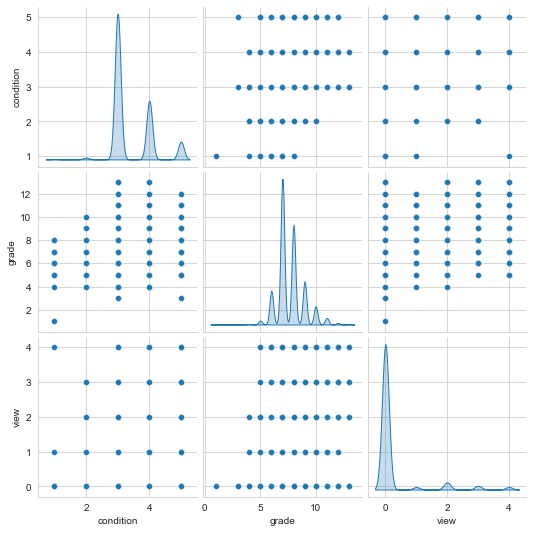

In [20]:
sns.pairplot(X[ordinal_features] , diag_kind='kde');

## A lot of colinearity between features here.

I do not think that we care about colinearity when we are working with a predictive model. From this article:https://www.kdnuggets.com/2019/08/predictor-collinearity.html I gleaned that provided you have several thousand observations, the influence of colinearity becomes vastly less important for a predictive model. I don't want to drop any of the columns. 

However, some of the columns should be and will be transformed. In particular, any feature that looks at square foot seems to be heavily skewed. 

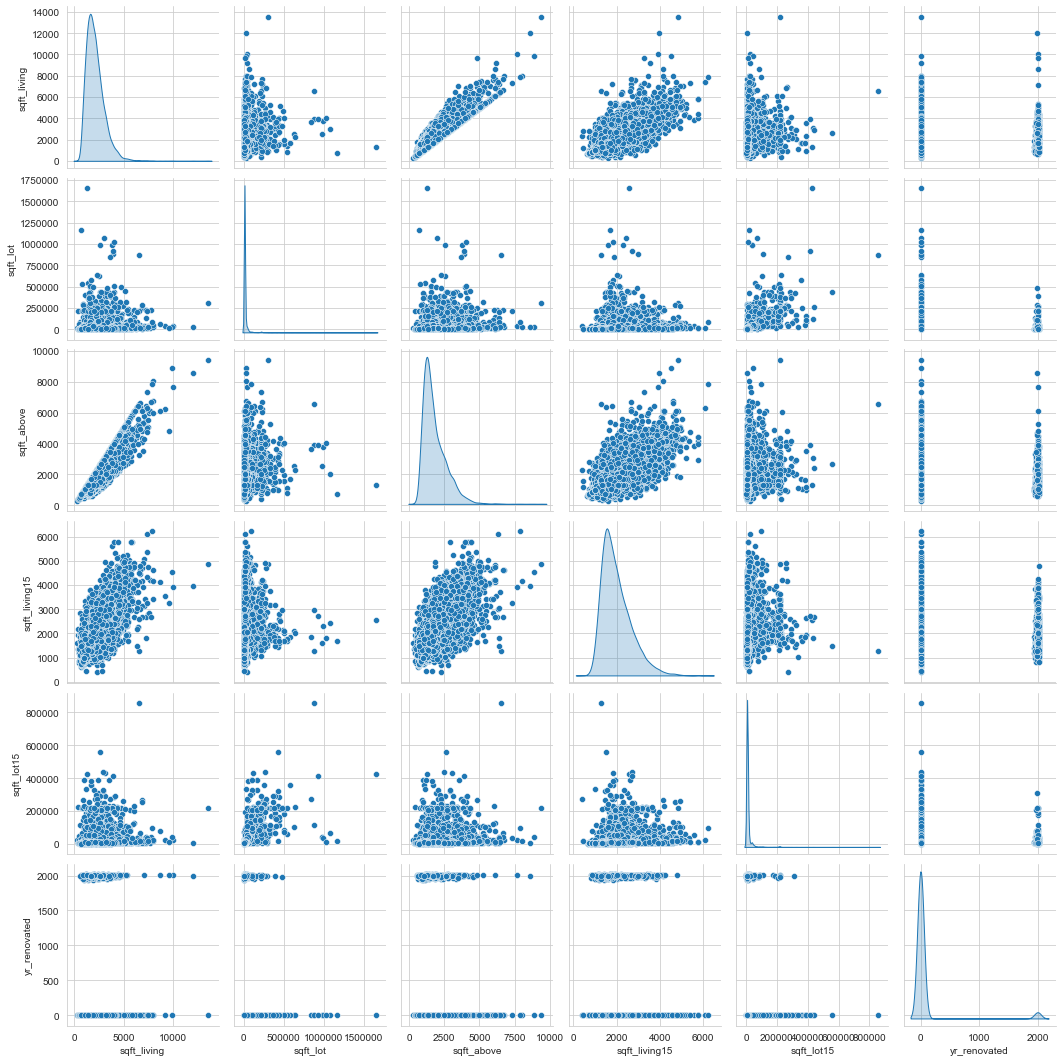

In [21]:
sns.pairplot(X[continuous_features] , diag_kind='kde');

## Understanding My Features

As we can see, there is definitely a linear interaction between bed and bath. Since I have a lot of features, I will not be testing them all individually. Indeed, analysing every interaction individually, will not always work considering the mutlidimensional structure of the data.

###  Interaction between bath bed and price

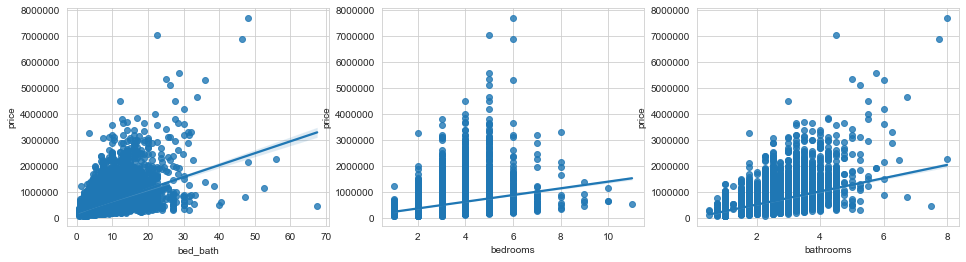

In [22]:
# Plotting beds and bath interaction 
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

X['bed_bath']= X.bathrooms * X.bedrooms

sns.regplot(x=X['bed_bath'], y=y, ax=ax1)
sns.regplot(x=X['bedrooms'], y=y, ax=ax2)
sns.regplot(x=X['bathrooms'], y=y, ax=ax3)
fig.savefig('./images/bath_bed.png', bbox_inches='tight');

In [23]:
formula = 'price~bedrooms+bathrooms+bed_bath'
model = ols(formula=formula, data=pd.concat([X,y], axis=1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     2466.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        22:17:08   Log-Likelihood:            -2.4329e+05
No. Observations:               17290   AIC:                         4.866e+05
Df Residuals:                   17286   BIC:                         4.866e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.968e+05   2.13e+04     18.649      0.000    3.55e+05    4.38e+05
bedrooms   -1.077e+05   6416.725    -16.782      0.000    -1.2e+05   -9.51e+04
bathrooms   2.601e+04   9962.440      2.611      0.009    6487.157    4.55e+04
bed_bath    6.036e+04   2607.431     23.150      0.000    5.53e+04    6.55e+04
==============================================================================
Omnibus:                    13145.582   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           623002.640
Skew:                           3.213   Prob(JB):                         0.00
Kurtosis:                      31.696   Cond. No.                         95.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###  Interaction between bath and price

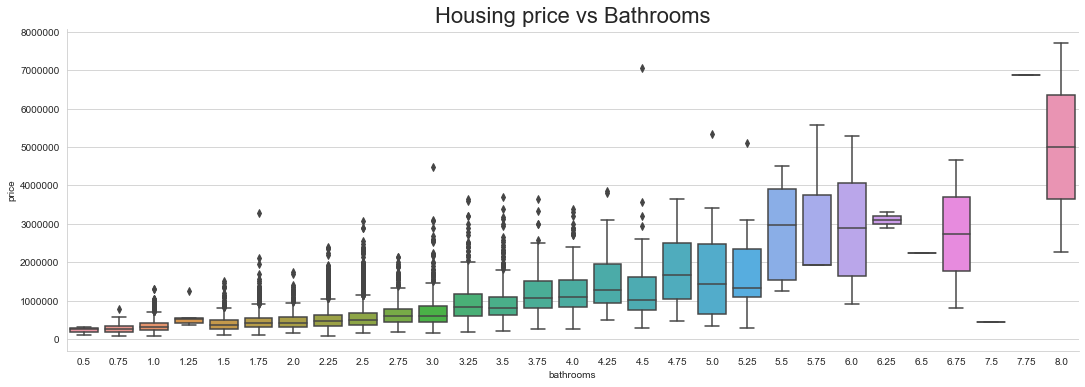

In [24]:
bathrooms= pd.concat([X['bathrooms'], y], axis=1)
sns.catplot(x='bathrooms',
            y='price', 
            data=bathrooms, 
            kind='box',
            height = 5,
            aspect = 3,
            ax=ax);
plt.title("Housing price vs Bathrooms", size = (22));

From visual inspection, we can see a very strong, potentially exponential relationship between number of bathrooms and housing price. Let's do a one way ANOVA test.

In [25]:
# Results were statistically signeficant.
f_oneway(bathrooms[bathrooms.bathrooms == 1.0].price,
        bathrooms[bathrooms.bathrooms == 2.0].price,
#         bathrooms[bathrooms.bathrooms == 3].price,
         bathrooms[bathrooms.bathrooms == 4].price,
#         bathrooms[bathrooms.bathrooms == 5.0].price,
        bathrooms[bathrooms.bathrooms == 6.0].price,
#         bathrooms[bathrooms.bathrooms == 7.0].price,
        bathrooms[bathrooms.bathrooms == 8.0].price,
        )

# Came back with strong evidence that there iis a relationship between this feature and price

F_onewayResult(statistic=997.9946513119061, pvalue=0.0)

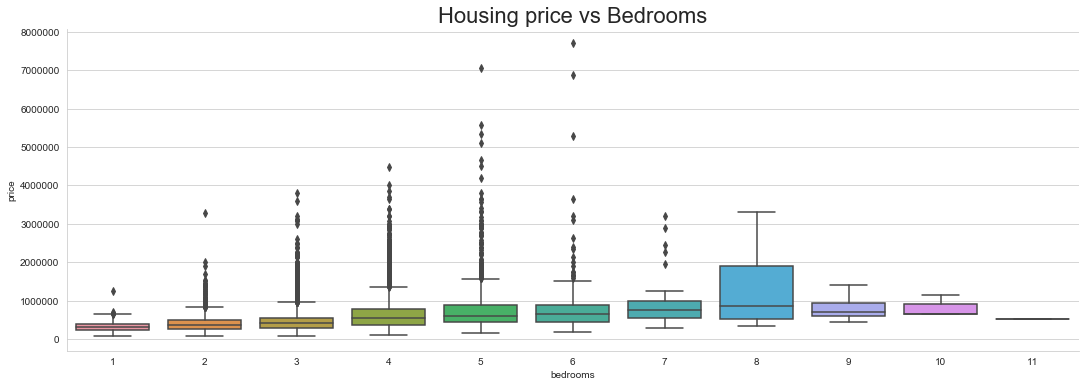

In [26]:
bedrooms = pd.concat([X['bedrooms'], y], axis=1)
sns.catplot(x='bedrooms',
            y='price', 
            data=bedrooms, 
            kind='box',
            height = 5,
            aspect = 3,
            ax=ax)
plt.title("Housing price vs Bedrooms", size=(22));

In [27]:
# Ran a non parametric test for bedrooms and price.
stats.kruskal(bedrooms[bedrooms.bedrooms==1].bedrooms,
             bedrooms[bedrooms.bedrooms==2].bedrooms,
             bedrooms[bedrooms.bedrooms==3].bedrooms)

KruskalResult(statistic=10240.000000000004, pvalue=0.0)

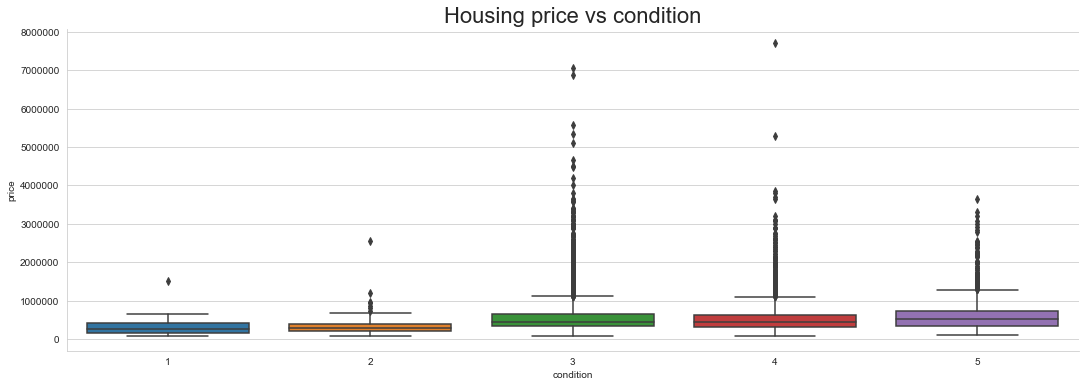

In [28]:
condition = pd.concat([X['condition'], y], axis=1)
sns.catplot(x='condition',
            y='price', 
            data=condition, 
            kind='box',
            height = 5,
            aspect = 3,
            ax=ax)
plt.title("Housing price vs condition", size=(22));

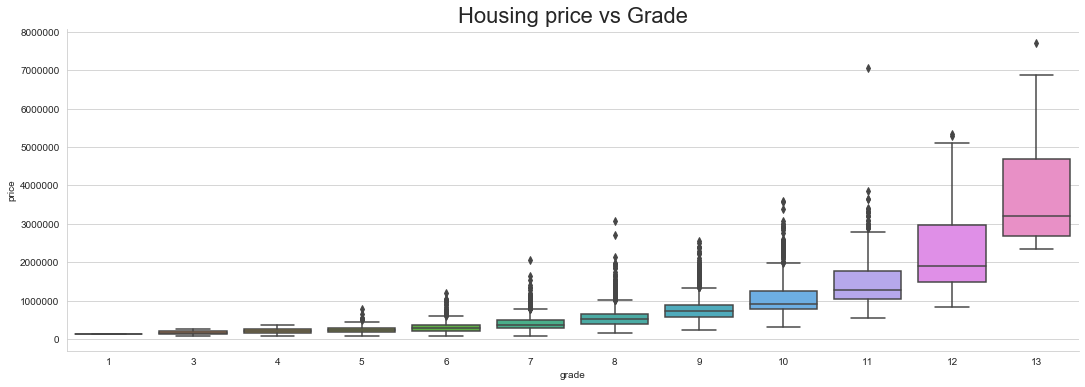

In [29]:
grade = pd.concat([(X['grade']), y], axis=1)
sns.catplot(x='grade',
            y='price', 
            data=grade, 
            kind='box',
            height = 5,
            aspect = 3,
            ax=ax)
plt.title("Housing price vs Grade", size=(22));

Visual inspeaction indeicated that there is a polynomial or exponential relationship between housing price and grade. If we 

# Piecewise model creation

### Imported my imputed X and y

imputation was based on research I conducted with a classmate using zillow. All of the bedbaths that had 0 were not actually 0. The mean bed bath of the 12 houses we looked at was not signeficantly different to the population mean so we imputed those values. 

In addition, there was 1 house with 33 bedrooms, after looking the house up I concluded that it actually has 3 bedrooms so i changed it's value

In [30]:
df_initial = pd.read_csv('./cleanedData/X.imputed.csv', index_col=0)
y = pd.read_csv('./raw/y.csv', header=None)
y.columns = ['price']
season_dummies = pd.read_csv('./cleanedData/seasonDummies.csv')

In [31]:
df_initial.shape

(17290, 20)

In [32]:
# concat the season dummies into the data frame
df = pd.concat([df_initial, season_dummies], axis=1)# 

In [33]:
df.shape

(17290, 22)

In [34]:
# Target feature number
df.shape[0]**0.5

131.49144458861193

## Dropping columns


In [35]:
to_drop = [
    'id', # arbitrary/random. Removed. 
    'date', # Adding polynomial week into the model, the rest handled by seasonality dummies
    'zipcode', # handled in dummy columbs
    'lat', # handled using geohashing
    'long' # handled using geohashing

]

In [36]:
df.drop(columns=to_drop, inplace=True)

In [37]:
df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,offpeak,peak
0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,2390,7700,0,0
1,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,2370,6283,0,0
2,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,3710,9685,0,0
3,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,4050,14226,0,0
4,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,2250,4050,0,0


In [38]:
df.shape

(17290, 17)

## change yr_built to house age and yr_renovated to age before poly variable creation

In [39]:
df.yr_built = df.yr_built.apply(lambda x: 2015-x)
df.yr_renovated = df.yr_renovated.apply(lambda x: 2015-x)

In [40]:
df.shape

(17290, 17)

## Add the polynomial and Interaction Features


In [41]:
# instantiate my polynomial object
poly = PolynomialFeatures(degree=2, include_bias=False)

In [42]:
# Create the interaction columns
poly_data = poly.fit_transform(df)
# Get the column names
poly_columns = poly.get_feature_names(df.columns)
# Create the new data frame
df_poly = pd.DataFrame(poly_data, columns=poly_columns)
# Look at the new data frame
df_poly.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,sqft_living15^2,sqft_living15 sqft_lot15,sqft_living15 offpeak,sqft_living15 peak,sqft_lot15^2,sqft_lot15 offpeak,sqft_lot15 peak,offpeak^2,offpeak peak,peak^2
0,4.0,2.25,2070.0,8893.0,2.0,0.0,0.0,4.0,8.0,2070.0,...,5712100.0,18403000.0,0.0,0.0,59290000.0,0.0,0.0,0.0,0.0,0.0
1,5.0,3.00,2900.0,6730.0,1.0,0.0,0.0,5.0,8.0,1830.0,...,5616900.0,14890710.0,0.0,0.0,39476089.0,0.0,0.0,0.0,0.0,0.0
2,4.0,2.50,3770.0,10893.0,2.0,0.0,2.0,3.0,11.0,3770.0,...,13764100.0,35931350.0,0.0,0.0,93799225.0,0.0,0.0,0.0,0.0,0.0
3,3.0,3.50,4560.0,14608.0,2.0,0.0,2.0,3.0,12.0,4560.0,...,16402500.0,57615300.0,0.0,0.0,202379076.0,0.0,0.0,0.0,0.0,0.0
4,3.0,2.50,2550.0,5376.0,2.0,0.0,0.0,3.0,9.0,2550.0,...,5062500.0,9112500.0,0.0,0.0,16402500.0,0.0,0.0,0.0,0.0,0.0


In [43]:
df_poly.shape, y.shape

((17290, 170), (17290, 1))

### Non-linear Transformations

I have three columns that have an non-linear relationship with price. I will also test the logarithmic relatioship of interactions.

In [44]:
df_poly.sqft_living = np.log(df.sqft_living)
df_poly.sqft_lot = np.log(df.sqft_lot)
df_poly.sqft_above = np.log(df.sqft_above)

# Add in weekly polynomials manually
df = pd.read_csv('./cleanedData/X.imputed.csv', index_col=0)
week = pd.to_datetime(df.date)
df_poly['week'] = week.dt.strftime("%W").astype(int)
df_poly['week^2'] = df_poly.week**2
df_poly['week^3'] = df_poly.week**3


### Test the new data frame

In [45]:
# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(df_poly, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )
# Test
lr_test = LinearRegression()
lr_test.fit(X_train, (y_train))
y_hat =lr_test.predict(X_train)
RMSE_test = mean_squared_error(y_train, (y_hat))

lr_first = LinearRegression()
lr_first.fit(X_train, (y_train))
y_hat =lr_first.predict(X_test)
RMSE_first = mean_squared_error(y_test, (y_hat))

print(f"Test RMSE is: {RMSE_test**0.5}")
print(f"With interaction and polynomial columns the RMSE of the model is: {RMSE_first**0.5}")

Test RMSE is: 182431.83686031128
With interaction and polynomial columns the RMSE of the model is: 188146.8939864338


## Add in zipcode data and test the new score 

Zipcodes were dummied and one was removed as a reference column.  

In [46]:
train_zipcode = pd.read_csv('./cleanedData/zipcodeDummies.csv')
poly_zip = pd.concat([df_poly, train_zipcode], axis=1) # poly zip is my new x variable

In [47]:
# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(poly_zip, y,               # Pass in our X and y
                                                    random_state=90,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )
# Test
lr_test = LinearRegression()
lr_test.fit(X_train, (y_train))
y_hat =lr_test.predict(X_train)
RMSE_test = mean_squared_error(y_train, (y_hat))

lr = LinearRegression()
lr.fit(X_train, (y_train))
y_hat =lr.predict(X_test)
RMSE_zip = mean_squared_error(y_test, (y_hat))


print(f"Test RMSE is: {RMSE_test**0.5}")
print(f"With just interaction and polynomial columns the RMSE of the model is: {RMSE_first**0.5}")
print(f"the RMSE of the model when you include dummy colums for zipcode is: {RMSE_zip**0.5}")

Test RMSE is: 128976.65428947443
With just interaction and polynomial columns the RMSE of the model is: 188146.8939864338
the RMSE of the model when you include dummy colums for zipcode is: 143200.4056382944


In [48]:
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
(cross_val_score(estimator=lr, X=X_train, y=y_train, cv = 10))

array([0.83605327, 0.85057017, 0.85361415, 0.84576445, 0.82717865,
       0.84174478, 0.85470144, 0.8563826 , 0.85934243, 0.87376943])

## Add in the geocoded data

In [49]:
geocoded = pd.read_csv('./cleanedData/geoOverlap.csv', index_col= 0)
poly_zip_geo = pd.concat([poly_zip, geocoded], axis=1)

In [50]:
# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(poly_zip_geo, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

# test
lr_test = LinearRegression()
lr_test.fit(X_train, (y_train))
y_hat =lr_test.predict(X_train)
RMSE_test = mean_squared_error(y_train, (y_hat))


lr = LinearRegression()
lr.fit(X_train, (y_train))
y_hat =lr.predict(X_test)
RMSE_final = mean_squared_error(y_test, (y_hat))

print(f"Test RMSE is: {RMSE_test**0.5}")
print(f"With just interaction and polynomial columns the RMSE of the model is: {RMSE_first**0.5}")
print(f"the RMSE of the model when you include dummy colums for zipcode is: {RMSE_zip**0.5}")
print(f"The RMSE after adding in the geocoded dummies is {RMSE_final**0.5}")

Test RMSE is: 124823.51227413912
With just interaction and polynomial columns the RMSE of the model is: 188146.8939864338
the RMSE of the model when you include dummy colums for zipcode is: 143200.4056382944
The RMSE after adding in the geocoded dummies is 129509.71038013471


In [51]:
# Error in comparison to the mean
RMSE_final**0.5/y_test.mean()

price    0.242911
dtype: float64

In [52]:
from sklearn.model_selection import cross_val_score
# lr = LinearRegression()
(cross_val_score(estimator=lr, X=X_train, y=y_train, cv = 10))

array([0.85283118, 0.74835564, 0.88807441, 0.85204564, 0.88298972,
       0.88821845, 0.85948829, 0.87382199, 0.86397271, 0.85389101])

## Model Validation

Linearity and Independance have already been violated. But Normality of the residuals and homoscedacity of the residuals should be checked 

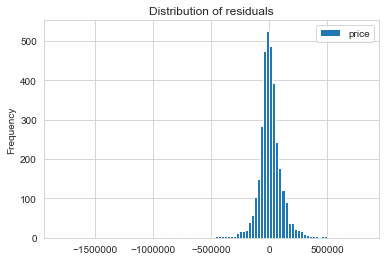

In [53]:
# Normality of the residual
residual_df = y_hat-y_test
residual_df.plot(kind='hist', bins=100)
plt.title("Distribution of residuals");

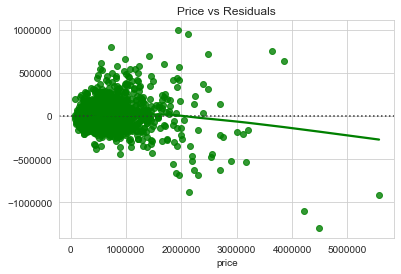

In [54]:
# homoscedacity doesn't look great. Potentially because we have too many variables. Lasso may fix this
sns.residplot(y_test, y_hat, lowess=True, color='g')
plt.title('Price vs Residuals');

# Feature Selection

I currently have 3x too many features in my model. It is producing consistent results but the model is too complex to interpret. I will run recursive feature selection and contrast that with Select K best to select my top 130 features to use. However, when I parse the features down, my results get significantly worse. I am happy that I checked, but I am goingto run with the features that I have

### Recursive Feature Selection 

Uncomment and run these at your own risk. I tried many different combinations but none were as good as my current model

In [55]:
# model = LinearRegression()
# rfe = RFE(estimator=model, n_features_to_select=1, step=1)
# rfe = rfe.fit(X_train, y_train)
# selected_rfe_features= pd.DataFrame({'Feature': list(X_train.columns),
#                                     'Ranking': rfe.ranking_})


In [56]:
# top_130 =selected_rfe_features.sort_values(by='Ranking')[:130].Feature.to_list()

In [57]:
# # Split the data into training and test data
# Xf_train, Xf_test, yf_train, yf_test = train_test_split(top_130_features_X, y,               # Pass in our X and y
#                                                     random_state=42,    # Abritary select a random_state 
#                                                     test_size=.2        # Split test size to be 20% of full data.
#                                                    )

# y_train.shape, X_train.shape

# lr = LinearRegression()
# lr.fit(Xf_train, (yf_train))
# yf_hat =lr.predict(Xf_test)
# RMSE_RFE = mean_squared_error(yf_test, (yf_hat))

# RMSE_RFE**0.5

#### Recursive Feature selection did not yeild better results

The RMSE went up by 100k. So next I will use a Lasso algorithm. This takes a long time to finish since I have so many features. I ran it once and it took around 20 minutes to complete. I do not reccomend you run this code

# Lasso 

For Lasso to converge, I first have to standarzie my continuous variables. My dummy variables are within 1 of eachother so they are fine


In [58]:
import pickle
scalar = StandardScaler()

In [59]:
# standardise continual data but not dummy
continuous = poly_zip_geo.iloc[:, :173]
dummy = poly_zip_geo.iloc[:,173:]

cont_scaled = scalar.fit_transform(continuous)
scaled_poly_zip_geo = pd.DataFrame(cont_scaled, columns=continuous.columns)
scaled_poly_zip_geo = pd.concat([scaled_poly_zip_geo, dummy], axis=1)
scaled_poly_zip_geo.to_csv('./cleanedData/xScaledFinal.csv')
scaled_poly_zip_geo.head()

# pickle the scalar
scalar_pickle_out = open("scalar.pickle","wb")
pickle.dump(scalar, scalar_pickle_out)
scalar_pickle_out.close()

In [60]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(scaled_poly_zip_geo, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )


ls = Lasso(alpha=0.1)
ls.fit(X_train, (y_train))
y_hat =ls.predict(X_test)
RMSE = mean_squared_error(y_test, (y_hat))
print(f"The RMSE using linear regression: {RMSE_final**0.5}")
print(f"RMSE using Lasso: {RMSE**0.5}")

The RMSE using linear regression: 129509.71038013471
RMSE using Lasso: 129791.12920360935


In [61]:
scaled_poly_zip_geo.shape

(17290, 420)

In [62]:
# intantiate the model and fit it
lasso = Lasso(alpha=0.1)
lasso.fit(scaled_poly_zip_geo, y)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [63]:
y_hat = lasso.predict(scaled_poly_zip_geo)
RMSE = mean_squared_error(y, (y_hat))
RMSE**0.5

125145.09602614667

In [64]:
# Save model
pickle_out = open("model.pickle","wb")
pickle.dump(lasso, pickle_out)
pickle_out.close()

In [65]:
# Load Lasso model
pickle_out = open("model.pickle","rb")
lasso = pickle.load(pickle_out)
pickle_out.close()

In [66]:
# I havn't done a train test splet of the data

In [67]:
# Cross validation takes a long time to return
#(cross_val_score(estimator=lasso, X=scaled_poly_zip_geo, y=y, cv = 10))

### Final model Validation

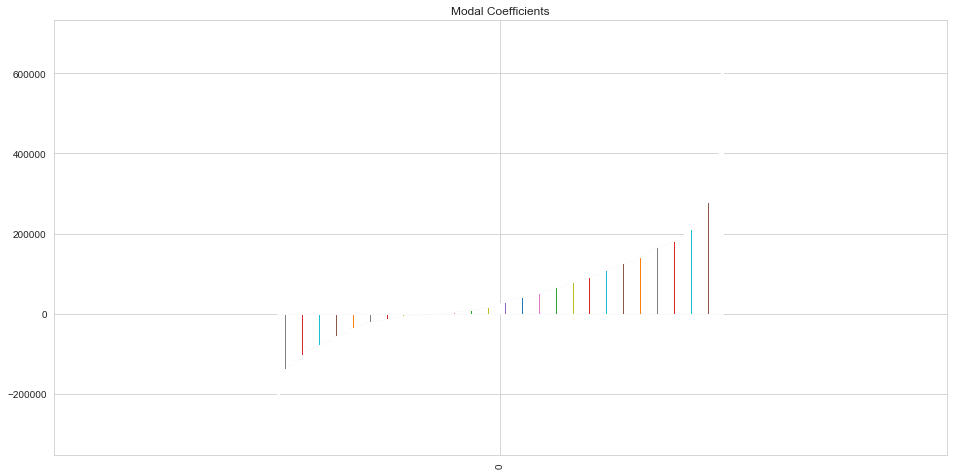

In [68]:
lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8));

In [69]:
y_hat.shape, y.shape

((17290,), (17290, 1))

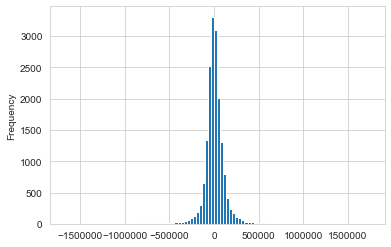

In [70]:
# Normality of the residuals
residual_df = y_hat-y.price
residual_df.plot(kind='hist', bins=100);

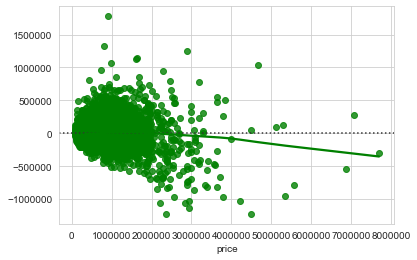

In [71]:
# homoscedacity 
sns.residplot(y, y_hat, lowess=True, color='g');

residuals correlate less with price than in the lr model. I think this model is better.

# Transform my holdout data

## Now that I have a model and it is pickled, I have create a perfectly mathcing holdout dataframe.

### pipepline

#### 1) Drop unwanted columns

#### 2) linear transformation of data

#### 3) add polynomial features

#### 4) non-linear transformations

#### 5) add zipcodes

#### 6) add in geocodes

In [72]:
X_holdout = holdout = pd.read_csv('./raw/kc_holdout_data.csv', index_col=0)
# Load my dummy data sets
holdoutZipcodes = pd.read_csv('./cleanedData/holdoutZipcodes.csv', index_col=0)
holdoutGeo = pd.read_csv('./cleanedData/holdoutGeo.csv', index_col=0)
holdoutSeason = pd.read_csv('./cleanedData/holdoutSeason.csv', index_col=0)

In [73]:
X_holdout.shape

(4323, 20)

In [74]:
X_holdout = pd.concat([X_holdout, holdoutSeason], axis=1)
X_holdout.shape,

((4323, 22),)

In [75]:
# drop the same columns that we dropped for our training data
X_holdout.drop(columns=to_drop, inplace=True)

In [76]:
X_holdout.shape, df.shape # after the drop 

((4323, 17), (17290, 20))

In [77]:
# Load my dummy data sets
holdoutZipcodes = pd.read_csv('./cleanedData/holdoutZipcodes.csv', index_col=0)
holdoutGeo = pd.read_csv('./cleanedData/holdoutGeo.csv', index_col=0)
holdoutSeason = pd.read_csv('./cleanedData/holdoutSeason.csv', index_col=0)

In [78]:
# Linear Transformation 
X_holdout.yr_built = df.yr_built.apply(lambda x: 2015-x)
X_holdout.yr_renovated = df.yr_renovated.apply(lambda x: 2015-x)

In [79]:
# Add polynomial features and interactions.
# Create the interaction columns
poly_data = poly.fit_transform(X_holdout)
# Get the column names
poly_columns = poly.get_feature_names(X_holdout.columns)
# Create the new data frame
df_poly_holdout = pd.DataFrame(poly_data, columns=poly_columns)
# Look at the new data frame
df_poly_holdout.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,sqft_living15^2,sqft_living15 sqft_lot15,sqft_living15 offpeak,sqft_living15 peak,sqft_lot15^2,sqft_lot15 offpeak,sqft_lot15 peak,offpeak^2,offpeak peak,peak^2
0,4.0,2.50,2270.0,11500.0,1.0,0.0,0.0,3.0,8.0,1540.0,...,4080400.0,22054360.0,0.0,0.0,119202724.0,0.0,0.0,0.0,0.0,0.0
1,4.0,2.50,2270.0,11500.0,1.0,0.0,0.0,3.0,8.0,1540.0,...,4080400.0,22054360.0,2020.0,0.0,119202724.0,10918.0,0.0,1.0,0.0,0.0
2,3.0,2.50,1470.0,1779.0,2.0,0.0,0.0,3.0,8.0,1160.0,...,2160900.0,2316720.0,1470.0,0.0,2483776.0,1576.0,0.0,1.0,0.0,0.0
3,3.0,1.75,1280.0,16200.0,1.0,0.0,0.0,3.0,8.0,1030.0,...,1345600.0,12255400.0,1160.0,0.0,111619225.0,10565.0,0.0,1.0,0.0,0.0
4,4.0,2.75,2830.0,8126.0,2.0,0.0,0.0,3.0,8.0,2830.0,...,8008900.0,22402280.0,2830.0,0.0,62663056.0,7916.0,0.0,1.0,0.0,0.0


In [80]:
# Add in non-linar transformations # note, I have to go back and apply the nonlinear trans to the main dataset

df_poly_holdout.sqft_living = np.log(df.sqft_living)
df_poly_holdout.sqft_lot = np.log(df.sqft_lot)
df_poly_holdout.sqft_above = np.log(df.sqft_above)

# Add in weekly polynomials manually
df = pd.read_csv('./raw/kc_holdout_data.csv', index_col=0)
week = pd.to_datetime(df.date)
df_poly_holdout['week'] = week.dt.strftime("%W").astype(int)
df_poly_holdout['week^2'] = df_poly_holdout.week**2
df_poly_holdout['week^3'] = df_poly_holdout.week**3

In [81]:
df_poly.shape, df_poly_holdout.shape

((17290, 173), (4323, 173))

In [82]:
# add zipcodes
holdout_poly_zip = pd.concat([df_poly_holdout, holdoutZipcodes], axis=1)
holdout_poly_zip.shape, poly_zip.shape

((4323, 243), (17290, 243))

In [83]:
# make sure the zipcodes are in the correct order
(holdoutZipcodes.columns == train_zipcode.columns).all()

True

In [84]:
# add in geocodes
holdoutGeo.shape, geocoded.shape

((4323, 177), (17290, 177))

In [85]:
holdout_zip_poly_geo = pd.concat([holdout_poly_zip, holdoutGeo], axis=1)

In [86]:
# check final shape
holdout_zip_poly_geo.shape, poly_zip_geo.shape

((4323, 420), (17290, 420))

In [87]:
# Check that all of the columns match.
(holdout_zip_poly_geo.columns == poly_zip_geo.columns).all()

True

### Fit a final linear regression

In [88]:
lr_final = LinearRegression().fit(poly_zip_geo, y)
y_hat = lr_final.predict(poly_zip_geo)
mean_squared_error(y, y_hat)**0.5

124819.22521567781

In [89]:
mean_squared_error(y,y_hat)**0.5/y.mean()

price    0.230831
dtype: float64

In [90]:
# Split the data into training and test data
Xf_train, Xf_test, yf_train, yf_test = train_test_split(poly_zip_geo, y,               # Pass in our X and y
                                                    random_state=5,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

y_train.shape, X_train.shape

lr = LinearRegression()
lr.fit(Xf_train, (yf_train))
yf_hat =lr.predict(Xf_test)
RMSE = mean_squared_error(yf_test, (yf_hat))

RMSE**0.5

132524.20123107167

## Standardise holdout for lasso

In [91]:
# scale cont variables
scaled_holdout_final_continuos = scalar.transform(holdout_zip_poly_geo.iloc[:, :173])

# make a dataframe from the standardised variables
scaled_holdout_cont_df = pd.DataFrame(scaled_holdout_final_continuos, 
                                      columns = holdout_zip_poly_geo.iloc[:, :173].columns)

holdout_dummies = holdout_zip_poly_geo.iloc[:,173:]

# put the data frame back together again
holdout_scaled_final = pd.concat([scaled_holdout_cont_df, holdout_dummies ], axis=1)

# Save my scaled data
holdout_scaled_final.to_csv('./cleanedData/holdoutScaledfinal.csv')

# Check the Distribution of the predicted vs the original data

Is lasso model better than lr_final?

In [92]:
y_hat_lr = lr_final.predict(holdout_zip_poly_geo)
y_hat_lasso = lasso.predict(holdout_scaled_final)

In [93]:
pd.DataFrame(y_hat_lasso, columns=['y_hat']).to_csv('./predictionLasso.csv')
pd.DataFrame(y_hat_lr, columns=['y_hat']).to_csv('./predictionsLr.csv')

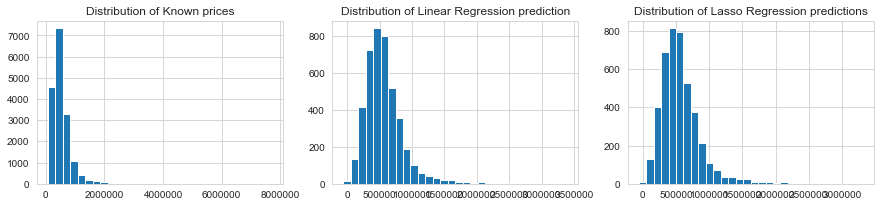

In [94]:
fig = plt.figure(figsize=(15,3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133);

ax1.hist(y.price, bins=30);
ax1.set_title("Distribution of Known prices");

ax2.hist(y_hat_lr, bins=30);
ax2.set_title("Distribution of Linear Regression prediction");

ax3.hist(y_hat_lasso,bins=30)
ax3.set_title("Distribution of Lasso Regression predictions");

fig.savefig('./images/predictionDistributions.png', bbox_inches = 'tight')

In [95]:
# predidction from our training data.
# pd.DataFrame(Lasso.predict(poly_zip_geo)).plot(kind='hist', bins= 100)

In [96]:
# test between y and linear regression model predictions
stats.ttest_ind(y, y_hat_lr)

Ttest_indResult(statistic=array([-4.63160274]), pvalue=array([3.6495926e-06]))

In [97]:
# test between y and lasso regression
stats.ttest_ind(y, y_hat_lasso)

Ttest_indResult(statistic=array([-4.44940721]), pvalue=array([8.65375747e-06]))

In [98]:
stats.ttest_ind(y_hat_lr, y_hat_lasso)

Ttest_indResult(statistic=array([0.15518388]), pvalue=array([0.87667998]))